### Import Libraries

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import copy

from sklearn.metrics import confusion_matrix
import pandas
import numpy as np

import requests
from PIL import Image
from io import BytesIO

In [30]:
numb_batch = 64

### Getting Data

In [31]:
T = torchvision.transforms.Compose([ToTensor()])

train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl= torch.utils.data.DataLoader(train_data, batch_size=numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=numb_batch)

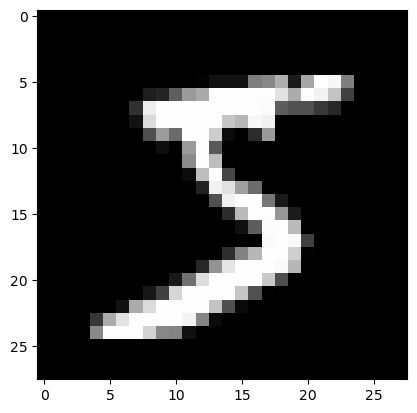

In [32]:
plt.imshow(train_data[0][0].squeeze(), cmap='gray')

### Create the Model

In [33]:
def create_lenet():
    model = nn.Sequential(
        # First Conv Layer
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        # Second Conv Layer
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        # Fully Connected Layer
        nn.Flatten(),
        nn.Linear(400, 120), # 400 = 16*5*5
        nn.ReLU(),
        nn.Linear(120, 84), # 120 = 16#
        nn.ReLU(),
        nn.Linear(84, 10)  # 84 = 10
    )
    return model

### Validate the Model

In [47]:
def validate(model, data, device):
    total = 0
    correct = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for i, (images, labels) in enumerate(data):
            images = images.to(device)
            labels = labels.to(device)
            x = model(images)
            _, pred = torch.max(x, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    model.train()  # Set the model back to training mode
    return correct * 100. / total

### Training Function

In [48]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0

    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl, device))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print("Epoch: ", epoch+1, "Accuracy: ", accuracy, '%')
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.show()
    return best_model


### GPU Availability

In [49]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

### Training the Model

Saving Best Model with Accuracy:  95.64
Epoch:  1 Accuracy:  95.64 %
Saving Best Model with Accuracy:  97.33
Epoch:  2 Accuracy:  97.33 %
Saving Best Model with Accuracy:  98.22
Epoch:  3 Accuracy:  98.22 %
Saving Best Model with Accuracy:  98.43
Epoch:  4 Accuracy:  98.43 %
Saving Best Model with Accuracy:  98.66
Epoch:  5 Accuracy:  98.66 %
Saving Best Model with Accuracy:  98.76
Epoch:  6 Accuracy:  98.76 %
Saving Best Model with Accuracy:  98.85
Epoch:  7 Accuracy:  98.85 %
Saving Best Model with Accuracy:  98.89
Epoch:  8 Accuracy:  98.89 %
Epoch:  9 Accuracy:  98.79 %
Epoch:  10 Accuracy:  98.79 %
Saving Best Model with Accuracy:  98.94
Epoch:  11 Accuracy:  98.94 %
Epoch:  12 Accuracy:  98.83 %
Saving Best Model with Accuracy:  98.99
Epoch:  13 Accuracy:  98.99 %
Saving Best Model with Accuracy:  99.03
Epoch:  14 Accuracy:  99.03 %
Epoch:  15 Accuracy:  98.96 %
Epoch:  16 Accuracy:  98.95 %
Epoch:  17 Accuracy:  99.0 %
Epoch:  18 Accuracy:  98.86 %
Epoch:  19 Accuracy:  98.93 %


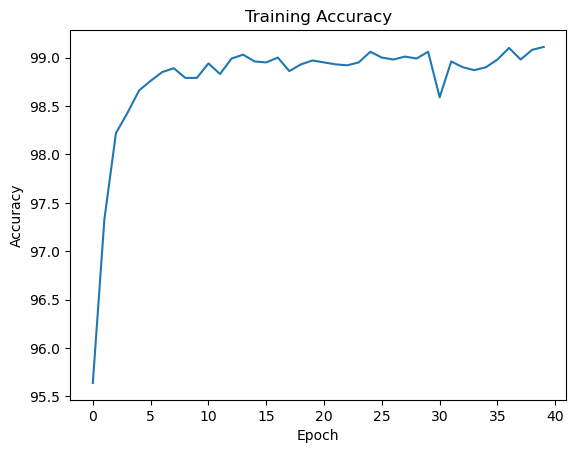

In [50]:
# Train the model
lenet = train(40, device=device)

In [57]:
def predict_dl(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            x = model(images)
            _, pred = torch.max(x, 1)
            y_pred.extend(list(pred.cpu().numpy()))  # Move tensor to CPU before converting to NumPy
            y_true.extend(list(labels.cpu().numpy()))  # Move tensor to CPU before converting to NumPy
    model.train()  # Set the model back to training mode
    return np.array(y_pred), np.array(y_true)

In [58]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Call the predict_dl function with the device argument
y_pred, y_true = predict_dl(lenet, val_dl, device)

In [59]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,0,0,2,1
1,0,1132,0,1,0,1,0,0,1,0
2,0,0,1020,1,1,0,1,9,0,0
3,1,0,1,998,0,2,0,3,2,3
4,0,0,0,0,970,0,4,0,2,6
5,0,0,0,4,0,884,1,0,0,3
6,1,2,0,0,1,6,948,0,0,0
7,0,1,1,0,0,0,0,1025,1,0
8,3,0,2,0,0,4,0,1,962,2
9,0,0,0,0,6,4,0,4,0,995


### Define Interface Function

In [68]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert('L')
        img = img.resize((28, 28))  # Corrected to use a tuple for the size
        x = (255 - np.expand_dims(np.array(img), -1)) / 255
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=1).cpu().numpy()

In [65]:
path = 'https://as1.ftcdn.net/v2/jpg/05/22/11/98/1000_F_522119800_fw1rdxPF1AVsgGjpVVkP1ma9o7XenJjI.jpg'
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert('L')
    img = img.resize((28, 28))  # Corrected to use a tuple for the size
    x = (255 - np.expand_dims(np.array(img), -1)) / 255

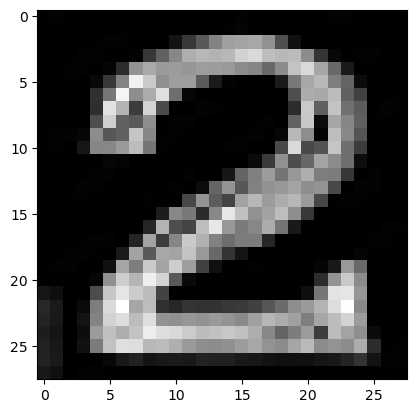

In [66]:
plt.imshow(x.squeeze(), cmap='gray')

### Predictions

In [70]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Probability: {pred[0][pred_idx]*100}%")

Predicted: 2, Probability: 0.9999643564224243%


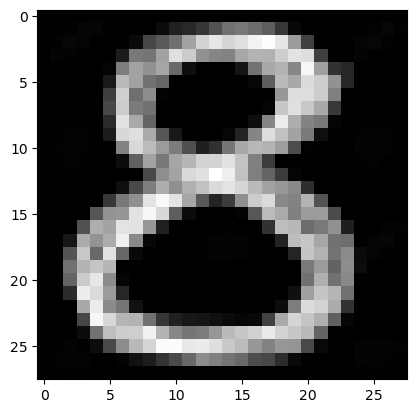

In [71]:
path = 'https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg'
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert('L')
    img = img.resize((28, 28))  # Corrected to use a tuple for the size
    x = (255 - np.expand_dims(np.array(img), -1)) / 255

plt.imshow(x.squeeze(), cmap='gray')

In [72]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Probability: {pred[0][pred_idx]*100}%")

Predicted: 8, Probability: 99.99990463256836%


In [73]:
pred

array([[9.1038323e-11, 6.5390418e-09, 9.2151106e-07, 4.7648867e-09,
        7.5472636e-13, 3.1130490e-10, 6.8067720e-08, 2.4703793e-16,
        9.9999905e-01, 6.4090388e-18]], dtype=float32)